In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm
import torch as torch
from datasets import load_dataset, load_from_disk
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
path = "/om2/user/jackking/modular_transformers/scripts/dimensionality_reduction"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Natural Language

## Natural Set

In [ ]:
string_len = 128
train_set_size = 20000
valid_set_size = 5000
datatype = "natural_language"

data_path = '/om/weka/evlab/ehoseini/MyData/miniBERTa_v2/'
grouped_pad_train = load_from_disk(
    os.path.join(data_path, f'miniBERTa-{10}M-crunched',
                    f'train_context_len_{512}'))
subset_idxs = np.random.choice(len(grouped_pad_train), train_set_size, replace=False)
subset = grouped_pad_train.select(subset_idxs)["input_ids"]
subset = [x[:string_len] for x in subset]

with open(f"{path}/data/{datatype}/train_data_natural.pkl", 'wb') as f:
    pickle.dump(subset, f)

data_path = '/om/weka/evlab/ehoseini/MyData/miniBERTa_v2/'
grouped_pad_train = load_from_disk(
    os.path.join(data_path, f'miniBERTa-{10}M-crunched',
                    f'valid_context_len_{512}'))
subset_idxs = np.random.choice(len(grouped_pad_train), valid_set_size, replace=False)
subset = grouped_pad_train.select(subset_idxs)["input_ids"]
subset = [x[:string_len] for x in subset]

with open(f"{path}/data/{datatype}/valid_data_natural.pkl", 'wb') as f:
    pickle.dump(subset, f)

## Gram Sets

In [ ]:
data_dir = "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
with open(data_dir, 'rb') as f:
    data = pickle.load(f)
tokenized_data = [tokenizer.encode(x) for x in data]
data = tokenized_data

In [9]:
string_len = 128
train_set_size = 20000
valid_set_size = 5000
datatype = "natural_language"

In [29]:
num_labels = 3
train_data = pickle.load(open(f"{path}/data/{datatype}/train_data_natural.pkl", 'rb'))
valid_data = pickle.load(open(f"{path}/data/{datatype}/valid_data_natural.pkl", 'rb'))
data = train_data + valid_data
random.shuffle(data)

partition_ratio = 1 / num_labels
partition_size = int(len(data) * partition_ratio)
chunked_data = [data[int(i * partition_size):int((i + 1) * partition_size)] for i in range(num_labels)]

In [11]:
def get_bigram_model_to_sample_from(data):
    bigram_model = {}
    for sentence in data:
        for i in range(len(sentence)-1):
            if sentence[i] in bigram_model:
                bigram_model[sentence[i]].append(sentence[i+1])
            else:
                bigram_model[sentence[i]] = [sentence[i+1]]
    return bigram_model

def sample_from_bigram_model(bigram_model, num_samples, string_len):
    samples = []
    bigram_model_keys = list(bigram_model.keys())
    for _ in tqdm(range(num_samples)):
        sample = [random.choice(bigram_model_keys)]
        for _ in range(string_len - 1):
            if sample[-1] not in bigram_model:
                sample.append(random.choice(bigram_model_keys))
            else:
                sample.append(random.choice(bigram_model[sample[-1]]))
        samples.append(sample)
    return samples

def get_trigram_model_to_sample_from(data):
    trigram_model = {}
    for sentence in data:
        for i in range(len(sentence) - 2):
            first_two = (sentence[i], sentence[i+1])
            if first_two in trigram_model:
                trigram_model[first_two].append(sentence[i+2])
            else:
                trigram_model[first_two] = [sentence[i+2]]
    
    return trigram_model

def sample_from_trigram_model(trigram_model, num_samples, string_len):
    samples = []
    trigram_model_keys = list(trigram_model.keys())
    for _ in tqdm(range(num_samples)):
        next_bigram = random.choice(trigram_model_keys)
        sample = [next_bigram[0], next_bigram[1]]
        for i in range(string_len - 2):
            first_two = (sample[-2], sample[-1])
            if first_two not in trigram_model:
                next_bigram = random.choice(trigram_model_keys)
                sample.append(next_bigram[0])
                sample.append(next_bigram[1])
                i += 1
            else:
                sample.append(random.choice(trigram_model[first_two]))
        
        if len(sample) > string_len:
            sample = sample[:string_len]
        samples.append(sample)
    return samples

def get_fourgram_model_to_sample_from(data):
    fourgram_model = {}
    for sentence in data:
        for i in range(len(sentence) - 3):
            first_three = (sentence[i], sentence[i+1], sentence[i+2])
            if first_three in fourgram_model:
                fourgram_model[first_three].append(sentence[i+3])
            else:
                fourgram_model[first_three] = [sentence[i+3]]
    
    return fourgram_model

def sample_from_fourgram_model(fourgram_model, num_samples, string_len):
    samples = []
    fourgram_model_keys = list(fourgram_model.keys())
    for _ in tqdm(range(num_samples)):
        next_trigram = random.choice(fourgram_model_keys)
        sample = [next_trigram[0], next_trigram[1], next_trigram[2]]
        for i in range(string_len - 3):
            first_three = (sample[-3], sample[-2], sample[-1])
            if first_three not in fourgram_model:
                next_trigram = random.choice(fourgram_model_keys)
                sample.append(next_trigram[0])
                sample.append(next_trigram[1])
                sample.append(next_trigram[2])
                i += 2
            else:
                sample.append(random.choice(fourgram_model[first_three]))
        if len(sample) > string_len:
            sample = sample[:string_len]
        samples.append(sample)
    return samples
        

In [13]:
def make_set(sub_datatype, model_fn, sample_fn):
    train_data = []
    valid_data = []
    train_labels = []
    valid_labels = []

    num_samples_per_label = int((train_set_size+valid_set_size) / num_labels)

    for i, data_chunk in enumerate(chunked_data):
        model = model_fn(data_chunk)
        data = sample_fn(model, num_samples_per_label, string_len)
        train_data += data[:int(len(data) * 0.8)]
        valid_data += data[int(len(data) * 0.8):]
        train_labels += [i] * len(data[:int(len(data) * 0.8)])
        valid_labels += [i] * len(data[int(len(data) * 0.8):])

    final_train = {"inputs": train_data, "labels": train_labels}
    final_valid = {"inputs": valid_data, "labels": valid_labels}

    with open(f"{path}/data/{datatype}/train_data_{sub_datatype}.pkl", 'wb') as f:
        pickle.dump(final_train, f)

    with open(f"{path}/data/{datatype}/valid_data_{sub_datatype}.pkl", 'wb') as f:
        pickle.dump(final_valid, f)

In [6]:
make_set("bigram", get_bigram_model_to_sample_from, sample_from_bigram_model)

100%|██████████| 5000/5000 [00:00<00:00, 12180.49it/s]


In [7]:
make_set("trigram", get_trigram_model_to_sample_from, sample_from_trigram_model)

100%|██████████| 5000/5000 [00:00<00:00, 5633.30it/s]


In [30]:
make_set("fourgram_B", get_fourgram_model_to_sample_from, sample_from_fourgram_model)

100%|██████████| 8333/8333 [00:01<00:00, 7597.68it/s]


### Visualize if class generators are all that different from each other

In [50]:
# models = []
keys = []
values = []
# for i, data_chunk in enumerate(chunked_data):
#     model = get_fourgram_model_to_sample_from(data_chunk)
#     models.append(model)
#     keys.extend(list(model.keys()))
#     for v in list(model.values()):
#         values.extend(v)

for model in models:
    keys.extend(list(model.keys()))

full_model = {}
for model in models:
    for key, value in model.items():
        if key in full_model:
            full_model[key] += value
        else:
            full_model[key] = value

keys = set(keys)
print(len(keys))
top_keys = sorted(keys, key=lambda x: len(full_model[x]), reverse=True)
sampled_keys = top_keys[:100]
num_keys = len(sampled_keys)
key_dict = {key: i for i, key in enumerate(sampled_keys)}

values = []
for key in sampled_keys:
    values.extend(full_model[key])
values = set(values)
num_values = len(values)
print(num_values)
value_dict = {value: i for i, value in enumerate(values)}

matrices = []
for model in models:
    matrix = np.zeros((num_keys, num_values))
    for first_word, second_words in tqdm(model.items()):
        if not first_word in key_dict:
            continue
        first_word = key_dict[first_word]
        for second_word in second_words:
            if not second_word in value_dict:
                continue
            second_word = value_dict[second_word]
            matrix[first_word, second_word] += 1
    matrices.append(matrix)

64674
3634


  0%|          | 0/36883 [00:00<?, ?it/s]

100%|██████████| 5333/5333 [00:00<00:00, 1550441.76it/s]


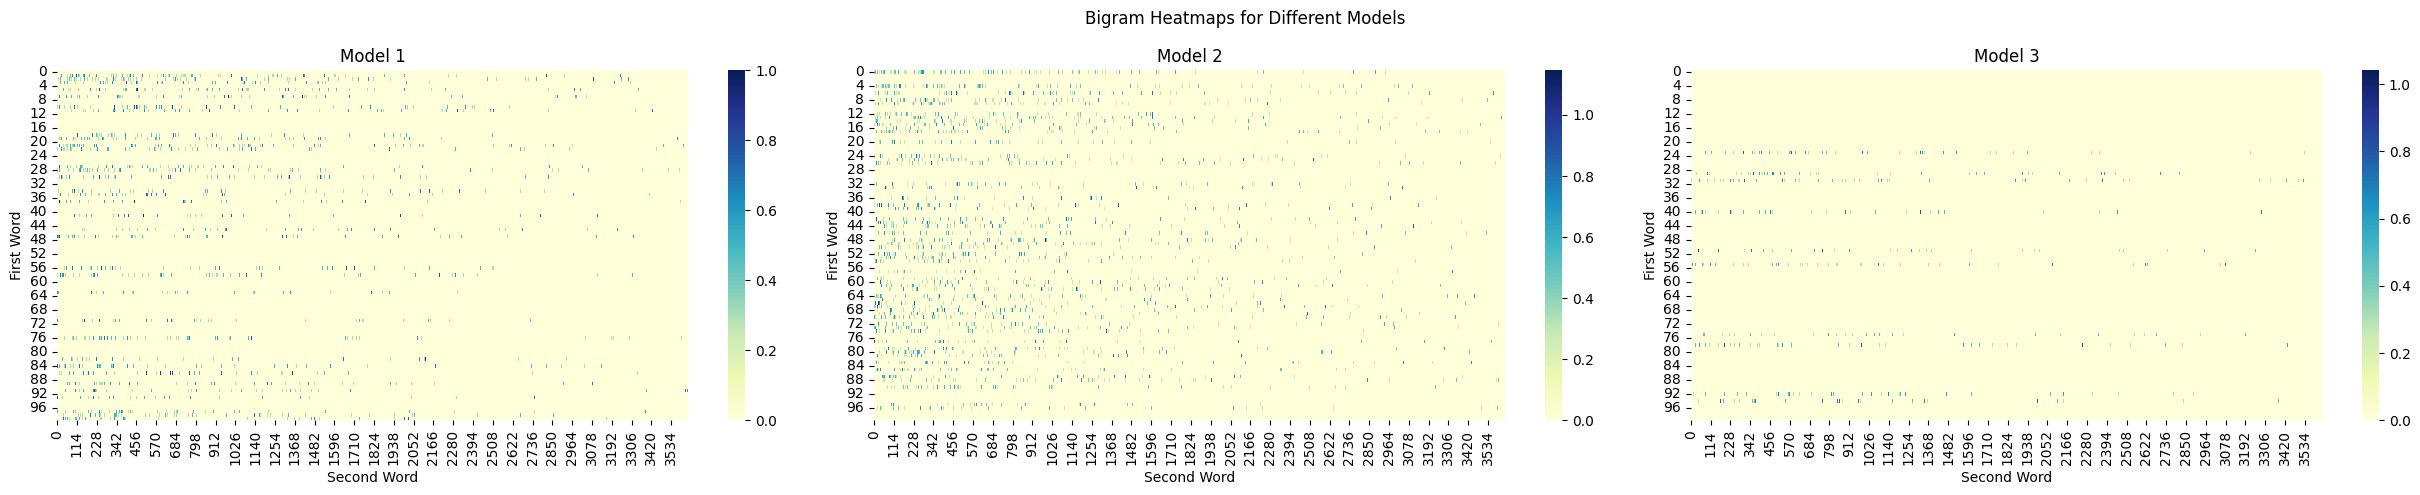

In [52]:
import seaborn as sns
from scipy.ndimage import zoom
from skimage.measure import block_reduce

fig, axes = plt.subplots(1, len(models), figsize=(25, 5))
fig.suptitle('Bigram Heatmaps for Different Models')

for i, matrix in enumerate(matrices):
    #squish values to be closer to each other and then average
    matrix = np.log10(matrix + 1)
    # matrix = zoom(matrix, 0.1)
    sns.heatmap(matrix, ax=axes[i], cmap="YlGnBu", cbar=True)
    axes[i].set_title(f'Model {i+1}')
    axes[i].set_xlabel('Second Word')
    axes[i].set_ylabel('First Word')

plt.tight_layout()
plt.show()

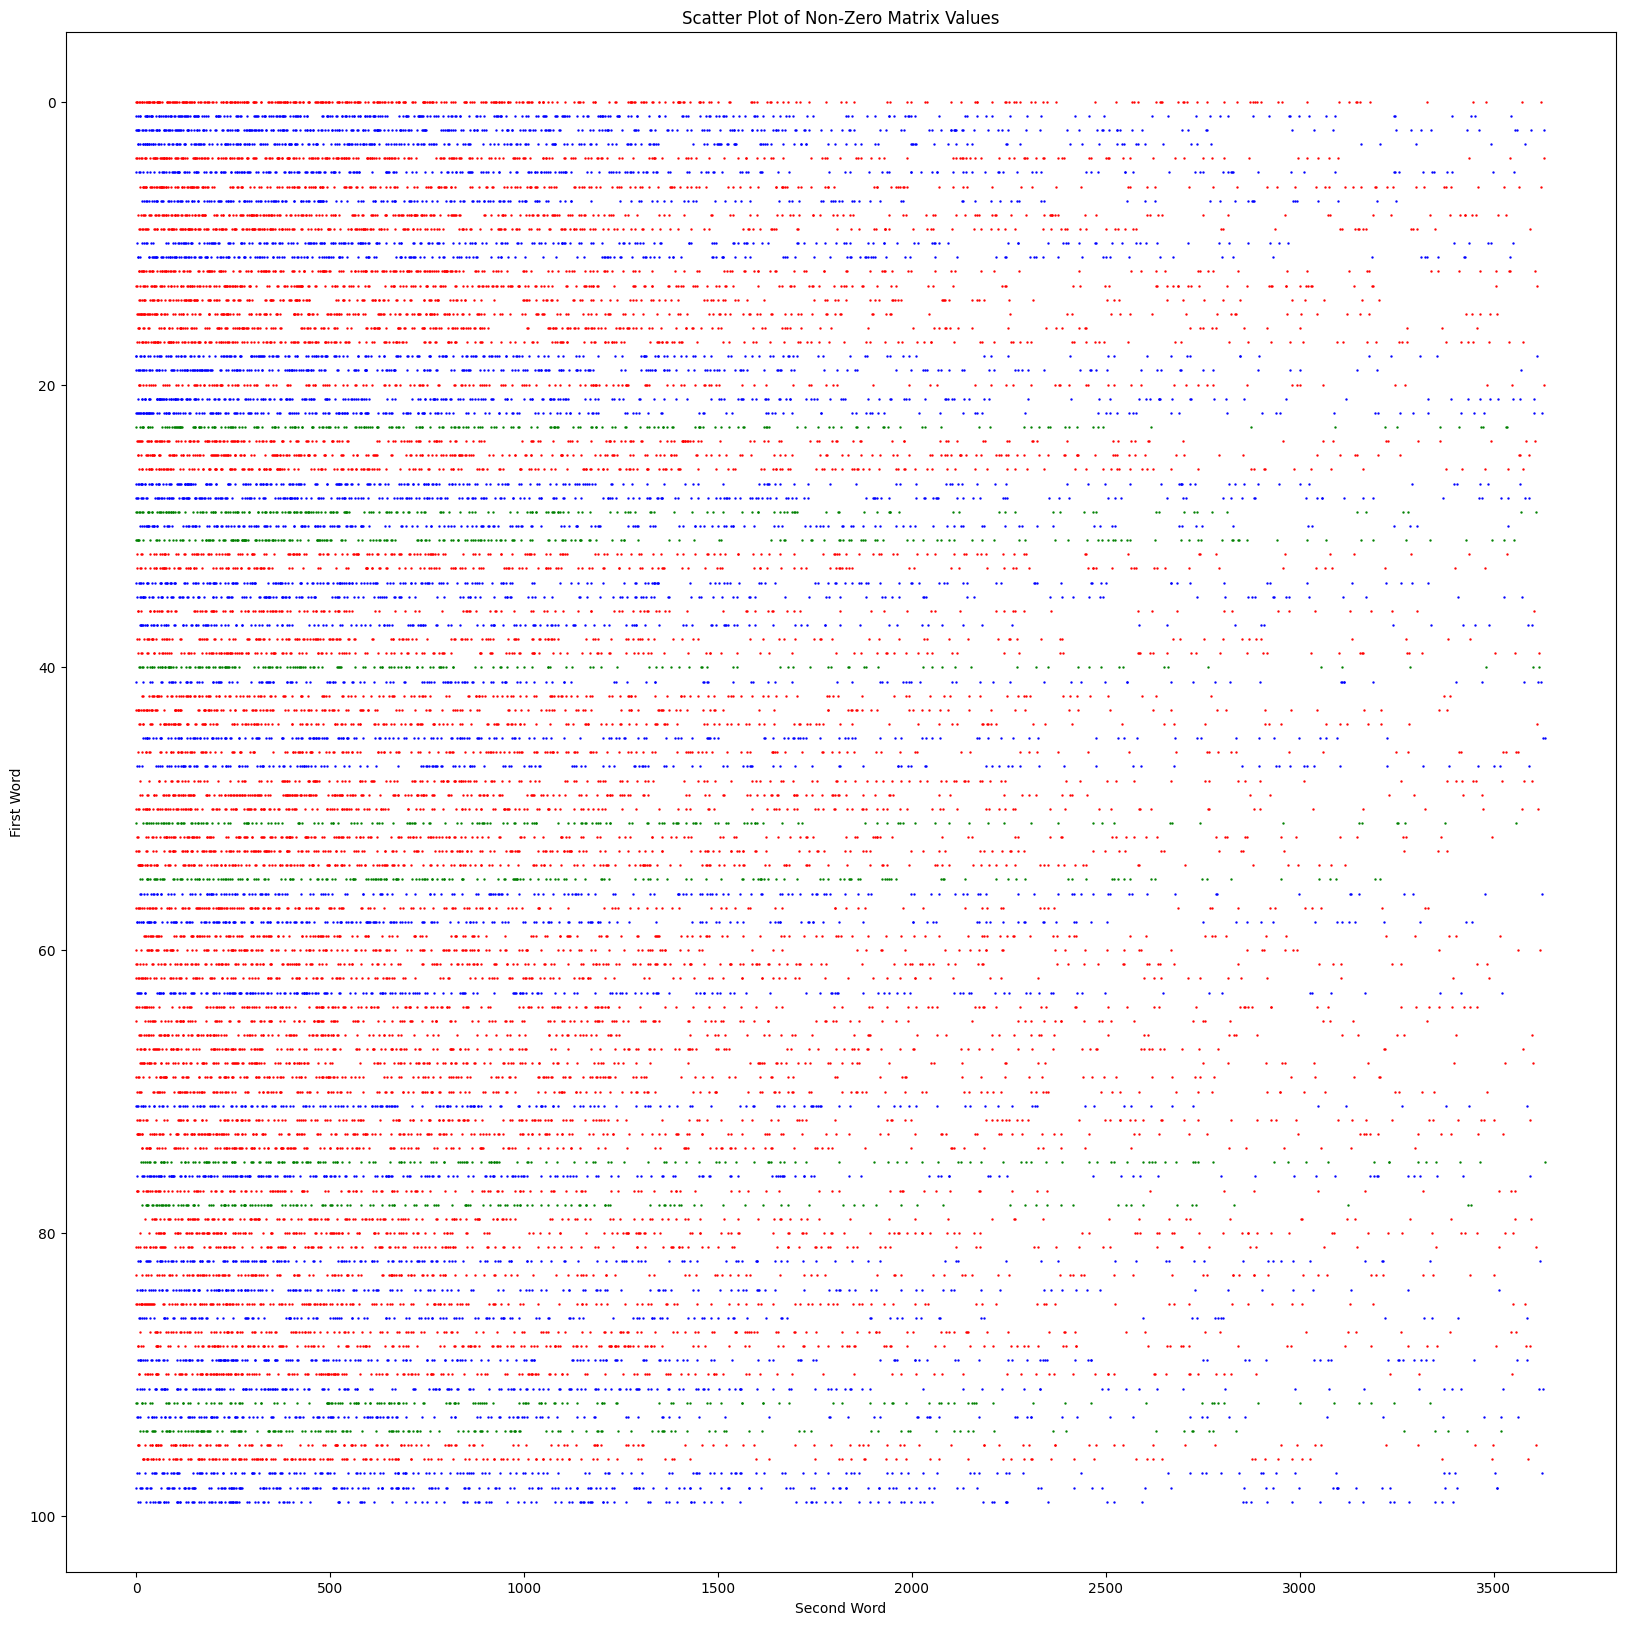

In [53]:
plt.figure(figsize=(20, 20))
rows, cols = np.nonzero(matrices[0])
plt.scatter(cols, rows, s=0.5, color='blue')  # 's' sets the marker size
rows, cols = np.nonzero(matrices[1])
plt.scatter(cols, rows, s=0.5, color='red')  # 's' sets the marker size
rows, cols = np.nonzero(matrices[2])
plt.scatter(cols, rows, s=0.5, color='green')  # 's' sets the marker size
# rows, cols = np.nonzero(matrices[3])
# plt.scatter(cols, rows, s=0.3, color='purple')  # 's' sets the marker size
# rows, cols = np.nonzero(matrices[4])
# plt.scatter(cols, rows, s=0.3, color='orange')  # 's' sets the marker size
plt.title('Scatter Plot of Non-Zero Matrix Values')
plt.xlabel('Second Word')
plt.ylabel('First Word')
plt.gca().invert_yaxis()  # Optional: invert y-axis to match typical matrix visualization
plt.show()

In [31]:
keys = []
for i, data_chunk in enumerate(chunked_data):
    model = get_fourgram_model_to_sample_from(data_chunk)
    keys.append(list(model.keys()))

tl = 0
for key in keys:
    tl += len(key)
print(tl)
shared_keys = list(set(keys[0]).intersection(*keys))
print(len(shared_keys))
shared_keys = list(filter(lambda x: len(model[x]) > 50, shared_keys))
print(len(shared_keys))

NameError: name 'chunked_data' is not defined

In [32]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(30, 30))
outer_grid = gridspec.GridSpec(3, 3, wspace=0.2, hspace=0.2)

for _ in range(9):
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 3,
                                                  subplot_spec=outer_grid[_], hspace=0.6, wspace=0.3)
    random_key = random.choice(shared_keys)
    for i, data_chunk in enumerate(chunked_data):
        model = get_fourgram_model_to_sample_from(data_chunk)
        continuation = model[random_key]
        ax = plt.Subplot(fig, inner_grid[i])
        # ax.hist(continuation, boxes=)
        unique_values, counts = np.unique(continuation, return_counts=True)
        # Create a bar plot
        ax.bar(unique_values, counts, width=0.5, align='center', color='blue', edgecolor='black')
        ax.set_title(f"Label {i}")
        fig.add_subplot(ax)

plt.show()


NameError: name 'shared_keys' is not defined

<Figure size 3000x3000 with 0 Axes>

# Toy Data

In [41]:
def create_toy_gram_model(n_grams):
    #model for sampling vocab
    vocab_len = 10000
    vocabulary = np.arange(vocab_len)
    vocab_model = np.exp(-vocabulary/vocab_len * 10)
    vocab_model = vocab_model/np.sum(vocab_model)

    #model for sampling number of values
    max_num_values = 1000
    possible_num_values = np.arange(1, max_num_values)
    possible_num_values_model = np.exp(-possible_num_values/max_num_values * 20)
    possible_num_values_model = possible_num_values_model/np.sum(possible_num_values_model)

    gram_model = {}
    max_depth = 4
    total_num_values = []

    def add_to_gram_model(key, depth):
        if depth == max_depth:
            return
        if key in gram_model:
            return

        num_values = int(np.random.choice(possible_num_values, p=possible_num_values_model))
        total_num_values.append(num_values)
        this_vocab = np.random.choice(vocabulary, num_values, p=vocab_model, replace=False)
        
        distribution_multiplier = np.random.normal(3, 1)
        if distribution_multiplier < 0:
            distribution_multiplier = 1
        vocab_indexes = np.arange(num_values)
        this_vocab_model = np.exp(-vocab_indexes/num_values * distribution_multiplier)
        this_vocab_model = this_vocab_model/np.sum(this_vocab_model)

        values = np.random.choice(this_vocab, num_values, p=this_vocab_model, replace=True)
        gram_model[key] = values

        for value in values:
            new_key = []
            for i in range(n_grams-1):
                new_key.append(key[i+1])
            new_key.append(value)
            add_to_gram_model(tuple(new_key), depth+1)

    first_key = np.random.choice(vocabulary, n_grams, p=vocab_model, replace=False)
    first_key = tuple(first_key)
    add_to_gram_model(first_key, 0)

    return gram_model

In [64]:
def make_toy_set(sub_datatype, num_classes, total_samples, context_len):
    train_data = []
    valid_data = []
    train_labels = []
    valid_labels = []

    num_samples_per_label = int(total_samples / num_classes)

    if "bigram" in sub_datatype:
        sample_fn = sample_from_bigram_model
        num_grams = 1
    elif "trigram" in sub_datatype:
        sample_fn = sample_from_trigram_model
        num_grams = 2
    elif "fourgram" in sub_datatype:
        sample_fn = sample_from_fourgram_model
        num_grams = 3

    for i in range(num_classes):

        model = create_toy_gram_model(num_grams)
        data = sample_fn(model, num_samples_per_label, context_len)

        train_data += data[:int(len(data) * 0.8)]
        valid_data += data[int(len(data) * 0.8):]
        train_labels += [i] * len(data[:int(len(data) * 0.8)])
        valid_labels += [i] * len(data[int(len(data) * 0.8):])

    final_train = {"inputs": train_data, "labels": train_labels}
    final_valid = {"inputs": valid_data, "labels": valid_labels}

    with open(f"{path}/data/toy/train_data_{sub_datatype}.pkl", 'wb') as f:
        pickle.dump(final_train, f)

    with open(f"{path}/data/toy/valid_data_{sub_datatype}.pkl", 'wb') as f:
        pickle.dump(final_valid, f)

In [65]:
#dataset parameters
num_samples = 25000
context_length = 128
n_classes = 3

make_toy_set("fourgram_A", n_classes, num_samples, context_length)

100%|██████████| 8333/8333 [00:00<00:00, 12185.67it/s]


# Cycles

## Full Cycle

In [71]:
vocab_len = 5000
vocabulary = np.arange(1, vocab_len, 1)
prob_model = np.exp(-vocabulary/vocab_len * 10)
prob_model = prob_model/np.sum(prob_model)

datatype = "cycle"
sub_datatype = "B"
context_length = 128
cycle_len = 24
num_samples = 21000
num_cycles = 3

#sample cycles from vocabulary
cycles = []
cycle_probs = []
for _ in range(num_cycles):
    sample = np.random.choice(vocabulary, size=cycle_len, p=prob_model, replace=False)
    cycles.append(sample)
    probs = np.random.uniform(0.7, 0.85, size=cycle_len)
    cycle_probs.append(probs)

In [72]:
samples = []
cycle_indexes = [] #labels
for sample_idx in tqdm(range(num_samples)):
    sample = []

    cycle_index = sample_idx % num_cycles
    cycle_indexes.append(cycle_index)
    cycle = cycles[cycle_index]

    token_index = np.random.choice(cycle_len)
    sample.append(cycle[token_index])

    for i in range(context_length-1):
        move_prob = cycle_probs[cycle_index][token_index]
        if np.random.uniform() < move_prob:
            next_token_increment = 1
        else: 
            next_token_increment = 0

        token_index = int((token_index+next_token_increment) % cycle_len)
        sample.append(cycle[token_index])
    
    samples.append(sample)

data_path = f"{path}/data"
cutoff = int(num_samples*(4/5))
train_data = {"inputs": samples[:cutoff], "labels": cycle_indexes[:cutoff]}
valid_data = {"inputs": samples[cutoff:], "labels": cycle_indexes[cutoff:]}

if not os.path.exists(f"{data_path}/{datatype}"):
    os.makedirs(f"{data_path}/{datatype}")

with open(f"{data_path}/{datatype}/train_data_{sub_datatype}.pkl", 'wb') as f:
    pickle.dump(train_data, f)

with open(f"{data_path}/{datatype}/valid_data_{sub_datatype}.pkl", 'wb') as f:
    pickle.dump(valid_data, f)
        

  2%|▏         | 342/21000 [00:00<00:06, 3416.07it/s]

100%|██████████| 21000/21000 [00:06<00:00, 3191.13it/s]


## Fragments

In [73]:
vocab_len = 5000
vocabulary = np.arange(1, vocab_len, 1)
prob_model = np.exp(-vocabulary/vocab_len * 10)
prob_model = prob_model/np.sum(prob_model)

datatype = "fragment"
sub_datatype = "B"
context_length = 128
cycle_len = 24
num_samples = 21000
num_cycles = 3

#sample cycles from vocabulary
cycles = []
cycle_probs = []
for _ in range(num_cycles):
    sample = np.random.choice(vocabulary, size=cycle_len, p=prob_model, replace=False)
    cycles.append(sample)
    probs = np.random.uniform(0.7, 0.85, size=cycle_len)
    cycle_probs.append(probs)

In [74]:
def break_integer(n, cycle_len):
    pieces = []
    low_end = int(cycle_len * (4/8))
    high_end = int(cycle_len * (7/8))
    while n > 0:
        piece = random.randint(low_end, high_end)
        if n - piece < 0:
            piece = n
        pieces.append(piece)
        n -= piece
    return pieces

In [75]:

samples = []
cycle_indexes = [] #labels
for sample_idx in tqdm(range(num_samples)):
    sample = []

    cycle_index = sample_idx % num_cycles
    cycle_indexes.append(cycle_index)
    cycle = cycles[cycle_index]
    fragment_sizes = break_integer(context_length, cycle_len)

    for size in fragment_sizes:

        token_index = random.randint(0, cycle_len-size-1)
        sample.append(cycle[token_index])

        for i in range(size-1):
            move_prob = cycle_probs[cycle_index][token_index]
            if np.random.uniform() < move_prob:
                next_token_increment = 1
            else: 
                next_token_increment = 0

            token_index = int(token_index+next_token_increment)
            sample.append(cycle[token_index])
    
    samples.append(sample)

data_path = f"{path}/data"
cutoff = int(num_samples*(4/5))
train_data = {"inputs": samples[:cutoff], "labels": cycle_indexes[:cutoff]}
valid_data = {"inputs": samples[cutoff:], "labels": cycle_indexes[cutoff:]}

if not os.path.exists(f"{data_path}/{datatype}"):
    os.makedirs(f"{data_path}/{datatype}")

with open(f"{data_path}/{datatype}/train_data_{sub_datatype}.pkl", 'wb') as f:
    pickle.dump(train_data, f)

with open(f"{data_path}/{datatype}/valid_data_{sub_datatype}.pkl", 'wb') as f:
    pickle.dump(valid_data, f)

100%|██████████| 21000/21000 [00:05<00:00, 3669.54it/s]
